# Importing necessary libraries

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn import svm
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import Imputer
import sklearn
import pandas
import random
import matplotlib.pyplot as plt
%matplotlib inline  

# Reading in file and defining variables

In [2]:
filter_by_baseline_flag = False
add_scale_cols_onehotencoder = False
add_missing_01_cols = False

raw_data = pandas.read_csv('contactid_08_29_18.csv', encoding="utf-8") 

raw_data_copy = raw_data

#Filling in empty cells

raw_data['Min days between calls'].fillna(0, inplace=True)
raw_data['Max days between calls'].fillna(0, inplace=True)
raw_data['Min days between texts'].fillna(0, inplace=True)
raw_data['Max days between texts'].fillna(0, inplace=True)  

raw_data.shape

(18265, 57)

# Filtering by baseline_flag

In [3]:
if filter_by_baseline_flag:
    raw_data = raw_data.loc[raw_data['baseline_flag']==0]
else :
    raw_data = raw_data.loc[raw_data['close'].notnull()] 
    

# Adding in columns for 0/1 for texts and calls

In [4]:
if add_missing_01_cols:
    calls_raw_data = pandas.get_dummies(raw_data['Total number of calls'], dummy_na=True, prefix='Calls')
    texts_raw_data = pandas.get_dummies(raw_data['Total number of texts'], dummy_na=True, prefix='Texts')

    raw_data = pandas.concat([raw_data, calls_raw_data['Calls_nan']],axis=1)
    raw_data = pandas.concat([raw_data, texts_raw_data['Texts_nan']],axis=1)

# Updating scale colunn to be replaced with onehotencoder layout

In [5]:
if add_scale_cols_onehotencoder:
    # use pandas.concat to join the new columns with dataframe
    raw_data = pandas.concat([raw_data,pandas.get_dummies(raw_data['scale'], prefix='scale')],axis=1)

    # now drop the original 'scale' column because we wont need it anymore
    raw_data.drop(['scale'],axis=1, inplace=True) 

In [6]:
# This will show us (# of rows, # of columns)
raw_data.shape

(2869, 57)

In [7]:
# Now we look over the workable data and see how clean it is

num_of_cells = raw_data.shape[0]*raw_data.shape[1]
num_of_cells

163533

In [8]:
# We look at all the columns with NaN values

df_null_columns = ((raw_data.isnull().sum()/raw_data.shape[0])*100).round(decimals=2).astype(str) + '%'
df_null_columns.to_frame('nulls')
#df_null_columns

,nulls
subjectid,0.0%
scale,0.0%
age,0.0%
black,0.0%
tot.child,0.03%
health.sr,0.0%
diag,0.0%
shelter,0.0%
recstay.yrs,0.0%
ageinc,0.0%


In [9]:
# We also look at all the rows with at least one NaN value

df_null_rows = raw_data.isnull().sum(axis=1)
# df_null_rows

In [10]:
# The percentage of rows missing at least one value would be

(((df_null_rows!=0).sum()/(df_null_rows.shape[0]))*100).round(decimals=2).astype(str) + '%'

'14.4%'

In [11]:
# And lastly we consider missing cells in relation to all total cells 

num_of_missing_cells = (raw_data.isnull().sum()).sum()
((num_of_missing_cells/num_of_cells)*100).round(decimals=2).astype(str) + '%'

'0.35%'

In [12]:
#Now we begin to train/test the data, in hopes of being able to most accurately predict the closeness column for the original file

# We begin by looking at 2 different introductory Models that helps us visualize the data

#GradientBoostingClassifier
#GradientBoostingRegressor

In [13]:
# Before we begin with these Models, we need to format the data in a manner in which we can work with
dfclean = raw_data.fillna(-1)

In [14]:
all_cols = set(dfclean.columns.values)
all_cols = all_cols.difference(['Contact.ID', 'close', 'baseline_flag', 'subjectid', 'cat', 'empstatus', 'svy_contact'])
xdata = dfclean[[i for i in all_cols]].values

In [15]:
# We implement a random 80/20 split of the data to be used for train/test

random.seed = 0
indices = np.array(range(raw_data.shape[0]))
random.shuffle(indices)
num_train = int(len(indices)*0.8)
train_indices = indices[:num_train]
#print(train_indices.shape)
test_indices =indices[num_train+1:]
#print(test_indices.shape)

# # namimg variables that will be used for training/testing
xtrain = xdata[train_indices]
xtest = xdata[test_indices]

# ravel creates 1d array
y = dfclean[['close']].values.ravel()
ytrain = y[train_indices]
ytest = y[test_indices]

# GradientBoostingClassifier

(array([ 208.,    0.,  137.,    0.,  106.,    0.,  343.,    0.,  356.,
        1145.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

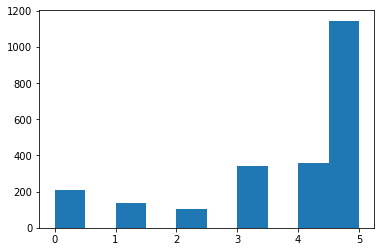

In [16]:
# GradientBoostingClassifier

def transform(ytrain):
    if ytrain < 20:
        return 0
    if ytrain < 40:
        return 1
    if ytrain < 60:
        return 2
    if ytrain < 80:
        return 3
    if ytrain < 100:
        return 4
    return 5


ytrainClassifier = [transform(i) for i in ytrain]
ytestClassifier = [transform(i) for i in ytest]
# ytestClassifier
# xtrain.shape,ytrain.shape
plt.hist(ytrainClassifier)

In [17]:
GBclassifier = GradientBoostingClassifier().fit(xtrain,ytrainClassifier)

yhatClassifier = GBclassifier.predict(xtrain)
yhatClassifier

array([0, 0, 5, ..., 5, 3, 5])

(array([ 44.,   0.,  18.,   0.,   5.,   0.,  38.,   0.,  38., 430.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

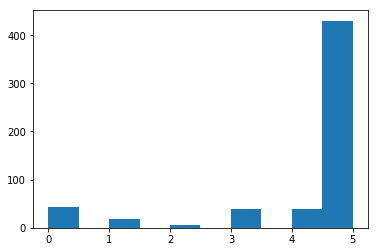

In [18]:
yhatClassifier = GBclassifier.predict(xtest)
accuracy_score(ytestClassifier, yhatClassifier)
plt.hist(yhatClassifier)

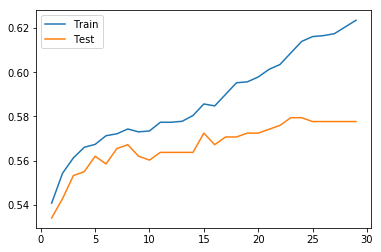

In [19]:
n_estimators = []
train_err = []
test_err = []

for n_estimator in range(1,30): #[1,2,3,4,5,10,20,50]:
    GBclassifier = GradientBoostingClassifier(n_estimators=n_estimator).fit(xtrain,ytrainClassifier)
    yhatClassifier = GBclassifier.predict(xtrain)
    n_estimators.append(n_estimator)
    train_err.append(accuracy_score(ytrainClassifier, yhatClassifier))
    test_err.append(accuracy_score(ytestClassifier, GBclassifier.predict(xtest)))
    
plt.plot(n_estimators, train_err, label="Train")
plt.plot(n_estimators, test_err, label="Test")
plt.legend()

plt.savefig('GBC_accuracy_base%s_scale%s_missing%s.png' % (filter_by_baseline_flag, add_scale_cols_onehotencoder, add_missing_01_cols))

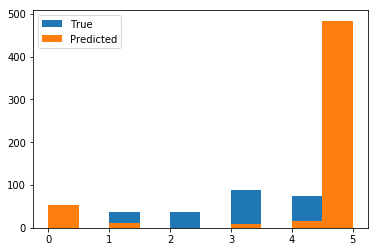

In [20]:
GBclassifier = GradientBoostingClassifier(n_estimators=20).fit(xtrain,ytrainClassifier)
plt.hist(ytestClassifier, label="True")
plt.hist(GBclassifier.predict(xtest), label="Predicted")
plt.legend()

plt.savefig('GBC_hist_base%s_scale%s_missing%s.png' % (filter_by_baseline_flag, add_scale_cols_onehotencoder, add_missing_01_cols))

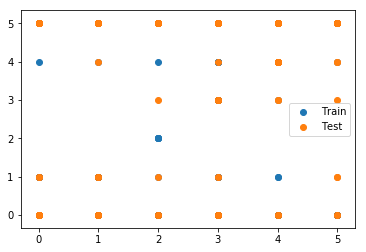

In [21]:
plt.scatter(ytrainClassifier, GBclassifier.predict(xtrain), label="Train")
plt.scatter(ytestClassifier, GBclassifier.predict(xtest), label="Test")
plt.legend()

plt.savefig('GBC_scatter_base%s_scale%s_missing%s.png' % (filter_by_baseline_flag, add_scale_cols_onehotencoder, add_missing_01_cols))

# GradientBoostingRegressor

In [22]:
# GradientBoostingRegressor

In [23]:
GBregressor = GradientBoostingRegressor().fit(xtrain,ytrain)
yhatRegressor = GBregressor.predict(xtrain)
yhatRegressor

array([55.81773325, 26.65768175, 60.81408327, ..., 74.25742084,
       78.15454702, 96.11550641])

In [24]:
yhatRegressor = GBregressor.predict(xtest)
mean_squared_error(ytest, yhatRegressor)

600.4825639729318

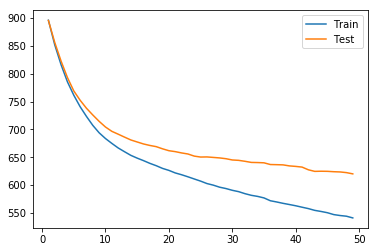

In [25]:
n_estimators = []
train_err = []
test_err = []

for n_estimator in range(1,50): #[1,2,3,4,5,10,20,50]:
    GBregressor = GradientBoostingRegressor(n_estimators=n_estimator).fit(xtrain,ytrain)
    yhatRegressor = GBregressor.predict(xtrain)
    n_estimators.append(n_estimator)
    train_err.append(mean_squared_error(ytrain, yhatRegressor))
    test_err.append(mean_squared_error(ytest, GBregressor.predict(xtest)))
    
plt.plot(n_estimators, train_err, label="Train")
plt.plot(n_estimators, test_err, label="Test")
plt.legend()

plt.savefig('GBR_MSerror_base%s_scale%s_missing%s.png' % (filter_by_baseline_flag, add_scale_cols_onehotencoder, add_missing_01_cols))

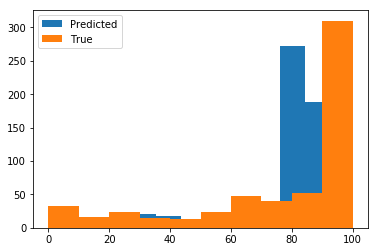

In [26]:
GBregressor = GradientBoostingRegressor(n_estimators=30).fit(xtrain,ytrain)
plt.hist(GBregressor.predict(xtest), label="Predicted")
plt.hist(ytest, label="True")
plt.legend()

plt.savefig('GBR_hist_base%s_scale%s_missing%s.png' % (filter_by_baseline_flag, add_scale_cols_onehotencoder, add_missing_01_cols))

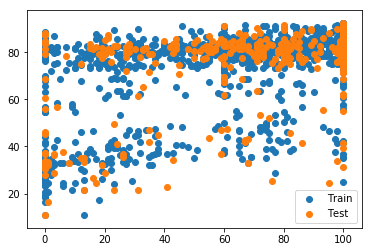

In [27]:
plt.scatter(ytrain, GBregressor.predict(xtrain), label="Train")
plt.scatter(ytest, GBregressor.predict(xtest), label="Test")
plt.legend()

plt.savefig('GBR_scatter_base%s_scale%s_missing%s.png' % (filter_by_baseline_flag, add_scale_cols_onehotencoder, add_missing_01_cols))

In [28]:
# We finally look at 2 different Advanced Models that helps us visualize the data
# SVR
# MLPRegressor
# Before we begin with these Models, we need to format the data in a manner in which we can work with

In [29]:
# Imputer and formatting data
# Before we begin with these Models, we need to format the data in a manner in which we can work with, but this time, is a smarter manner using an Imputer to populate missing values for us

all_cols = set(dfclean.columns.values)
all_cols = all_cols.difference(['Contact.ID', 'close', 'baseline_flag', 'subjectid', 'cat', 'empstatus', 'svy_contact'])
xmissing = dfclean[[i for i in all_cols]].values

# dfRawFilled = pandas.DataFrame(data=xdata)
imp = Imputer()
xdataimputed = imp.fit_transform(xmissing)
xdataimputed

array([[6.66666687e-01, 3.33333343e-01, 1.00000000e+00, ...,
        0.00000000e+00, 1.42000000e+02, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 5.00000000e-01, 0.00000000e+00, ...,
        1.00000000e+00, 7.80000000e+01, 0.00000000e+00],
       ...,
       [3.33333373e-01, 1.66666672e-01, 1.00000000e+00, ...,
        1.00000000e+00, 7.56000000e+02, 0.00000000e+00],
       [9.49152529e-01, 4.74576265e-01, 1.00000000e+00, ...,
        1.00000000e+00, 8.43600000e+03, 1.00000000e+00],
       [1.00000024e-01, 5.00000010e-02, 1.00000000e+00, ...,
        1.00000000e+00, 3.69500000e+03, 1.00000000e+00]])

In [30]:
xdataimputed.shape

(2869, 50)

In [31]:
# We implement a random 80/20 split of the data to be used for train/test
# namimg variables that will be used for training/testing
xtrain = xdataimputed[train_indices]
xtest = xdataimputed[test_indices]

# ravel creates 1d array
y = dfclean[['close']].values.ravel()
ytrain = y[train_indices]
ytest = y[test_indices]

# SVR

In [32]:
# SVR

svr = SVR(kernel='rbf', C=1e1, epsilon=0.2)
svr.fit(xtrain, ytrain)
yhatsvr = svr.predict(xtest)
yhatsvr

array([91.31542285, 91.35897057, 91.31542285, 91.31542285, 91.31542285,
       91.31542285, 98.19331816, 99.24230689, 91.31542285, 91.31614174,
       91.29856051, 91.31542285, 91.31542285, 91.31542285, 91.31542285,
       91.31542285, 91.31542285, 91.31542285, 91.31542285, 91.31542191,
       87.34999855, 91.31542285, 91.31542285, 86.85862599, 91.91191595,
       91.31542613, 91.31542284, 91.31542285, 91.31542285, 91.31542285,
       91.31542285, 91.31542285, 91.31542285, 91.31542285, 92.25466558,
       91.31371246, 91.31542285, 90.37507912, 91.31542285, 91.31542285,
       91.31542285, 91.31542285, 91.31542285, 91.31542285, 91.40100566,
       91.31542285, 90.22375173, 91.31542285, 91.31542285, 91.31542285,
       91.31542285, 91.31542285, 87.39409418, 72.8316529 , 90.84932751,
       91.31532176, 91.31542285, 91.31520606, 91.3153394 , 91.31542285,
       91.31542285, 90.990143  , 92.66729174, 90.24091454, 91.31542285,
       91.31542285, 91.31542285, 91.27521653, 91.31542285, 89.07

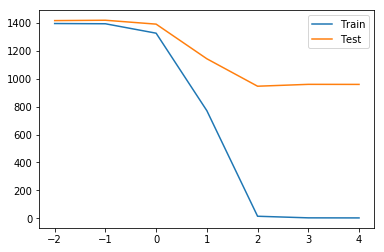

In [33]:
lCs = []
train_err = []
test_err = []

for lC in range(-2,5): #[1,2,3,4,5,10,20,50]: range(1,30)
    svr = SVR(kernel='rbf', C=pow(10,lC)).fit(xtrain,ytrain)
    lCs.append(lC)
    train_err.append(mean_squared_error(ytrain, svr.predict(xtrain)))
    test_err.append(mean_squared_error(ytest, svr.predict(xtest)))
    
plt.plot(lCs, train_err, label="Train")
plt.plot(lCs, test_err, label="Test")
plt.legend()

plt.savefig('SVR_MSerror_base%s_scale%s_missing%s.png' % (filter_by_baseline_flag, add_scale_cols_onehotencoder, add_missing_01_cols))

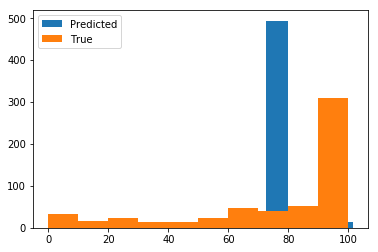

In [34]:
svr = SVR(kernel='rbf', C=1e2).fit(xtrain,ytrain)
plt.hist(svr.predict(xtest), label="Predicted")
plt.hist(ytest, label="True")
plt.legend()

plt.savefig('SVR_hist_base%s_scale%s_missing%s.png' % (filter_by_baseline_flag, add_scale_cols_onehotencoder, add_missing_01_cols))

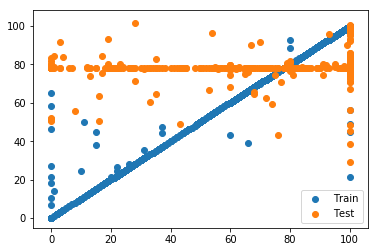

In [35]:
plt.scatter(ytrain, svr.predict(xtrain), label="Train")
plt.scatter(ytest, svr.predict(xtest), label="Test")
plt.legend()

plt.savefig('SVR_scatter_base%s_scale%s_missing%s.png' % (filter_by_baseline_flag, add_scale_cols_onehotencoder, add_missing_01_cols))

# MLPRegressor

In [36]:
# MLPRegressor
mlp = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(5,2))
mlp.fit(xtrain, ytrain)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [37]:
yhat = mlp.predict(xtest)
mean_squared_error(ytest, mlp.predict(xtest))

1148.6979983033655

(array([ 37.,  99., 113., 128., 103.,  61.,  22.,   7.,   2.,   1.]),
 array([ 46.1808198 ,  54.63159898,  63.08237817,  71.53315735,
         79.98393653,  88.43471572,  96.8854949 , 105.33627408,
        113.78705327, 122.23783245, 130.68861163]),
 <a list of 10 Patch objects>)

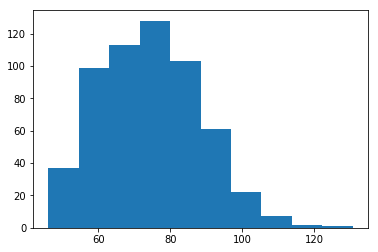

In [38]:
plt.hist(yhat)

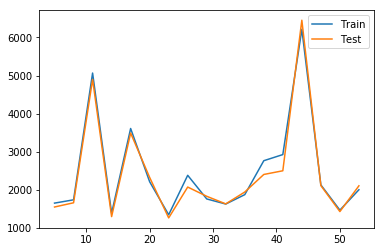

In [39]:
hs = []
train_err = []
test_err = []

for h in range(5,55,3): #[1,2,3,4,5,10,20,50]: range(1,30)
    mlp = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(h,5))
    mlp.fit(xtrain, ytrain)
    hs.append(h)
    train_err.append(mean_squared_error(ytrain, mlp.predict(xtrain)))
    test_err.append(mean_squared_error(ytest, mlp.predict(xtest)))
    
plt.plot(hs, train_err, label="Train")
plt.plot(hs, test_err, label="Test")
plt.legend()

plt.savefig('MLP_MSerror_base%s_scale%s_missing%s.png' % (filter_by_baseline_flag, add_scale_cols_onehotencoder, add_missing_01_cols))

In [40]:
all_cols = set(raw_data.columns.values)
all_cols = all_cols.difference(['Contact.ID', 'close', 'baseline_flag', 'subjectid', 'cat', 'empstatus', 'svy_contact'])
xdatafull = dfclean[[i for i in all_cols]].values

In [41]:
dfRawFilledFull = pandas.DataFrame(data=xdatafull)
#print(dfRawFilledFull)

In [42]:
imp = Imputer()
imp.fit(dfRawFilledFull)
imp.transform(dfRawFilledFull.values)
dfRawFilledFull = pandas.DataFrame(data=(imp.transform(dfRawFilledFull.values)))
dfRawFilledFull

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.666667,0.333333,1.0,6.0,1.0,4.0,0.0,1.0,0.0,1.0,...,1.0,30.0,2.0,1.0,0.0,0.0,1.0,0.0,142.0,1.0
1,0.000000,1.000000,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,32.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.000000,0.500000,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,24.0,1.0,0.0,0.0,0.0,0.0,1.0,78.0,0.0
3,0.830189,0.415094,1.0,159.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,58.0,18.0,0.0,14.0,0.0,0.0,1.0,21764.0,1.0
4,0.666667,0.666667,1.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,47.0,7.0,0.0,2.0,0.0,0.0,1.0,85.0,0.0
5,0.000000,1.000000,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,51.0,7.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,0.500000,0.250000,1.0,8.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,41.0,15.0,0.0,0.0,0.0,0.0,1.0,342.0,1.0
7,0.750000,0.375000,1.0,8.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,35.0,6.0,0.0,0.0,0.0,0.0,0.0,474.0,0.0
8,0.526316,0.263158,1.0,38.0,0.0,15.0,1.0,0.0,0.0,0.0,...,0.0,21.0,1.0,0.0,3.0,0.0,1.0,1.0,9295.0,1.0
9,0.936170,0.531915,1.0,47.0,1.0,7.0,0.0,0.0,0.0,1.0,...,0.0,25.0,2.0,1.0,9.0,1.0,1.0,1.0,5754.0,1.0


In [43]:
# update x to use values that have been populated now
xdatafullColumns = dfRawFilledFull[[i for i in range(dfRawFilledFull.columns.size)]].values

In [44]:
GBregressor = GradientBoostingRegressor().fit(xtrain,ytrain)
yhatRegressor = GBregressor.predict(xdatafullColumns)

# Do one last final predict on best results and feed out 
raw_data['Predicted Closeness'] = yhatRegressor

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [45]:
# Finally we write out the new dataFrame with the "Predicted Closeness" column

dfPredictions = raw_data.to_csv('Updated_Closeness_Predictions_base%s_scale%s_missing%s.csv' % (filter_by_baseline_flag, add_scale_cols_onehotencoder, add_missing_01_cols), encoding="utf-8")